# University of Mannheim
## Data Mining I -- Group Project
### Wine Quality Prediction
#### Team members:
* Anna-Lena Blinken
* Max Darmstadt
* Nicolas Hautschek
* Erik Penther
* Nicolas Fürhaupter

## Importing Libraries and Data

In [81]:
#from google.colab import drive
#drive.mount('/gdrive')
#%cd /gdrive

In [82]:
# Import libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split

from sklearn.tree import DecisionTreeClassifier
from sklearn.pipeline import Pipeline

from sklearn.metrics import mean_squared_error, r2_score
from sklearn.metrics import classification_report
from math import sqrt
from sklearn.model_selection import cross_val_score
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score

from sklearn.metrics import confusion_matrix
import itertools

# Imports
from sklearn.metrics import make_scorer
from sklearn.metrics import accuracy_score
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_predict

from imblearn.over_sampling import SMOTE 
from collections import Counter

In [83]:
# Import wine data

wine_data = pd.read_csv('../winequalityN.csv')
wine_data.head()

,type,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,white,7.0,0.27,0.36,20.7,0.045,45.0,170.0,1.0010,3.00,0.45,8.8,6
1,white,6.3,0.30,0.34,1.6,0.049,14.0,132.0,0.9940,3.30,0.49,9.5,6
2,white,8.1,0.28,0.40,6.9,0.050,30.0,97.0,0.9951,3.26,0.44,10.1,6
3,white,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6
4,white,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6


In [84]:
def get_scores_train(target, predictions):
    print("Makro F1-Score Train Data:")
    f1_score_train_knn = f1_score(target, predictions, average='macro')
    display(f1_score_train_knn)
    print("Makro Precision Train Data:")
    precision_train_knn = precision_score(target, predictions, average='macro', zero_division = 0)
    display(precision_train_knn)
    print("Makro Recall Train Data:")
    recall_train_knn = recall_score(target, predictions, average='macro')
    display(recall_train_knn)

def get_scores_test(target, predictions):
    print("Makro F1-Score Test Data:")
    f1_score_test_knn = f1_score(target, predictions, average='macro')
    display(f1_score_test_knn)
    print("Makro Precision Test Data:")
    precision_test_knn = precision_score(target, predictions, average='macro', zero_division = 0)
    display(precision_test_knn)
    print("Makro Recall Test Data:")
    recall_test_knn = recall_score(target, predictions, average='macro')
    display(recall_test_knn)
    

# Function to plot a confusion matrix
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

## Visualize and Analyse Data

In [85]:
# Print wine data info

wine_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6497 entries, 0 to 6496
Data columns (total 13 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   type                  6497 non-null   object 
 1   fixed acidity         6487 non-null   float64
 2   volatile acidity      6489 non-null   float64
 3   citric acid           6494 non-null   float64
 4   residual sugar        6495 non-null   float64
 5   chlorides             6495 non-null   float64
 6   free sulfur dioxide   6497 non-null   float64
 7   total sulfur dioxide  6497 non-null   float64
 8   density               6497 non-null   float64
 9   pH                    6488 non-null   float64
 10  sulphates             6493 non-null   float64
 11  alcohol               6497 non-null   float64
 12  quality               6497 non-null   int64  
dtypes: float64(11), int64(1), object(1)
memory usage: 660.0+ KB


In [86]:
# Analyse the data by its mean etc.

wine_data.describe()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
count,6487.000000,6489.000000,6494.000000,6495.000000,6495.000000,6497.000000,6497.000000,6497.000000,6488.000000,6493.000000,6497.000000,6497.000000
mean,7.216579,0.339691,0.318722,5.444326,0.056042,30.525319,115.744574,0.994697,3.218395,0.531215,10.491801,5.818378
std,1.296750,0.164649,0.145265,4.758125,0.035036,17.749400,56.521855,0.002999,0.160748,0.148814,1.192712,0.873255
min,3.800000,0.080000,0.000000,0.600000,0.009000,1.000000,6.000000,0.987110,2.720000,0.220000,8.000000,3.000000
25%,6.400000,0.230000,0.250000,1.800000,0.038000,17.000000,77.000000,0.992340,3.110000,0.430000,9.500000,5.000000
50%,7.000000,0.290000,0.310000,3.000000,0.047000,29.000000,118.000000,0.994890,3.210000,0.510000,10.300000,6.000000
75%,7.700000,0.400000,0.390000,8.100000,0.065000,41.000000,156.000000,0.996990,3.320000,0.600000,11.300000,6.000000
max,15.900000,1.580000,1.660000,65.800000,0.611000,289.000000,440.000000,1.038980,4.010000,2.000000,14.900000,9.000000


### Null Values

In [87]:
# Check data for null values

wine_data.isnull().sum()

type                     0
fixed acidity           10
volatile acidity         8
citric acid              3
residual sugar           2
chlorides                2
free sulfur dioxide      0
total sulfur dioxide     0
density                  0
pH                       9
sulphates                4
alcohol                  0
quality                  0
dtype: int64

In [88]:
# Check class distribution

wine_data.quality.value_counts()

6    2836
5    2138
7    1079
4     216
8     193
3      30
9       5
Name: quality, dtype: int64

### Class Distribution

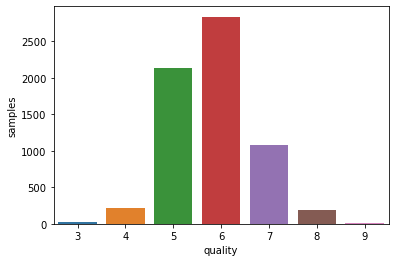

In [89]:
# Visualize class distribution

sns.barplot(x=wine_data.quality.value_counts().index, y=wine_data.quality.value_counts())
plt.ylabel('samples')
plt.xlabel('quality')
plt.show()

In [90]:
# Turn 10 classes into 3 classes

wine_data['quality'] = wine_data.quality.apply(lambda x: 2 if x>6 else (1 if x> 4 else 0))

In [91]:
# Check class distribution

wine_data.quality.value_counts()

1    4974
2    1277
0     246
Name: quality, dtype: int64

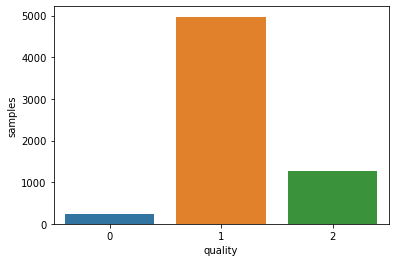

In [92]:
# Visualize class distribution

sns.barplot(x=wine_data.quality.value_counts().index, y=wine_data.quality.value_counts())
plt.ylabel('samples')
plt.xlabel('quality')
plt.show()

In [93]:
# Turn 10 classes into 2 classes

wine_data_2 = pd.read_csv('../winequalityN.csv')
wine_data_2['quality'] = wine_data_2.quality.apply(lambda x: 2 if x>5 else 0)

In [94]:
# Check class distribution

wine_data_2.quality.value_counts()

2    4113
0    2384
Name: quality, dtype: int64

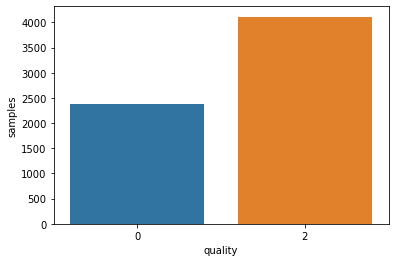

In [95]:
# Visualize class distribution

sns.barplot(x=wine_data_2.quality.value_counts().index, y=wine_data_2.quality.value_counts())
plt.ylabel('samples')
plt.xlabel('quality')
plt.show()

### Check duplicates

In [96]:
# Count duplicates and remove duplicates
display(len(wine_data.index))
wine_data.drop_duplicates()
display(len(wine_data.index))

6497

6497

### Unique Values

In [97]:
# Count uniques values of each column
wine_data.nunique()

type                      2
fixed acidity           106
volatile acidity        187
citric acid              89
residual sugar          316
chlorides               214
free sulfur dioxide     135
total sulfur dioxide    276
density                 998
pH                      108
sulphates               111
alcohol                 111
quality                   3
dtype: int64

### Distribution of Values

<AxesSubplot:>

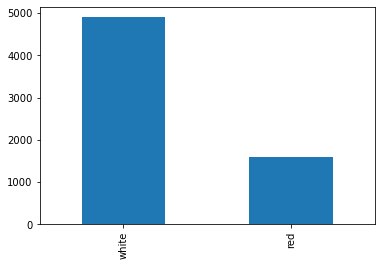

In [98]:
# Plot histogram for each categorical column

wine_data['type'].value_counts().plot(kind='bar')

array([[<AxesSubplot:title={'center':'fixed acidity'}>,
        <AxesSubplot:title={'center':'volatile acidity'}>,
        <AxesSubplot:title={'center':'citric acid'}>],
       [<AxesSubplot:title={'center':'residual sugar'}>,
        <AxesSubplot:title={'center':'chlorides'}>,
        <AxesSubplot:title={'center':'free sulfur dioxide'}>],
       [<AxesSubplot:title={'center':'total sulfur dioxide'}>,
        <AxesSubplot:title={'center':'density'}>,
        <AxesSubplot:title={'center':'pH'}>],
       [<AxesSubplot:title={'center':'sulphates'}>,
        <AxesSubplot:title={'center':'alcohol'}>,
        <AxesSubplot:title={'center':'quality'}>]], dtype=object)

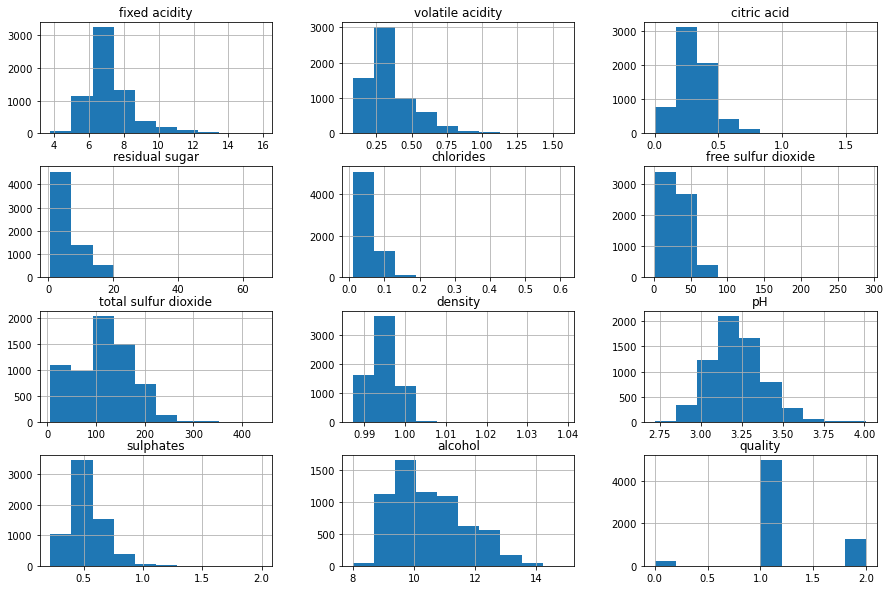

In [99]:
# Plot histogram for each numerical column

wine_data.hist(figsize=(15, 10))

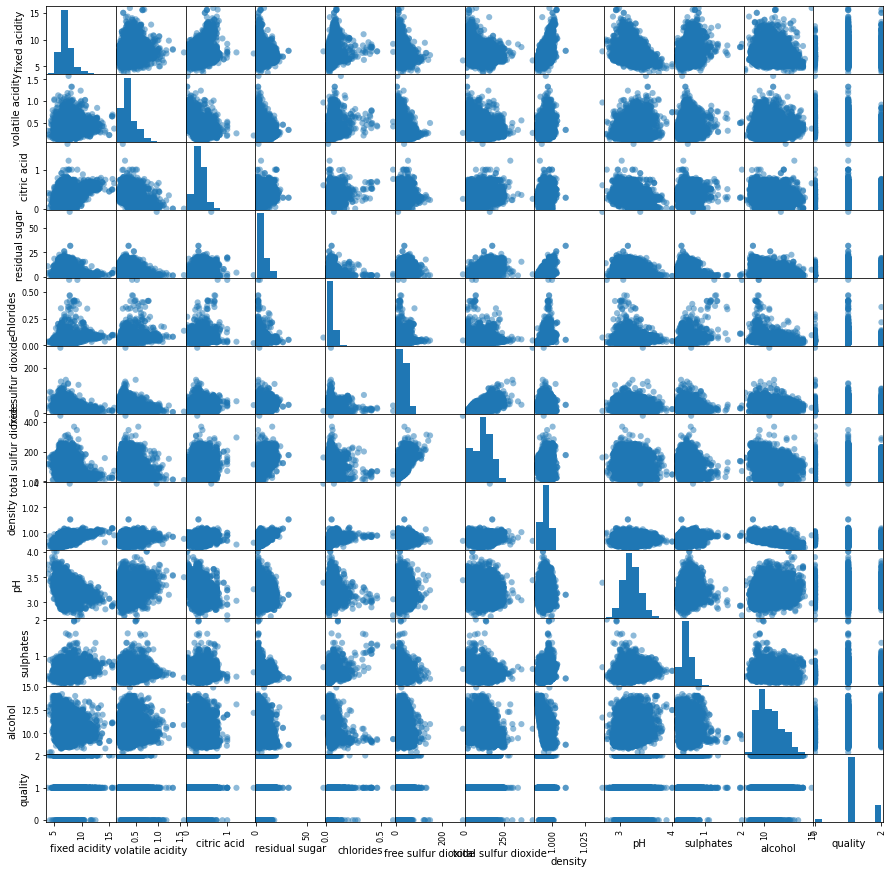

In [100]:
# Scatterplots

pd.plotting.scatter_matrix(wine_data, figsize=(15, 15), s=150);

## Data Cleaning

In [101]:
# Delete Null-Values 

wine_data = wine_data.dropna(axis=0, how="any", thresh=None, subset=None, inplace=False)
display(wine_data.isnull().sum())
display(len(wine_data.index))

type                    0
fixed acidity           0
volatile acidity        0
citric acid             0
residual sugar          0
chlorides               0
free sulfur dioxide     0
total sulfur dioxide    0
density                 0
pH                      0
sulphates               0
alcohol                 0
quality                 0
dtype: int64

6463

In [102]:
# One Hot Encoder for the attribute type

from sklearn import preprocessing

# show data before preprocessing
display(wine_data.head())

# create the OrdinalEncoder
ordinal_encoder = preprocessing.OrdinalEncoder()

# preprocess the features Product and ZipCode
wine_data = wine_data.copy()
wine_data[['type']] = ordinal_encoder.fit_transform(wine_data[['type']])

# show the results
wine_data.head()

,type,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,white,7.0,0.27,0.36,20.7,0.045,45.0,170.0,1.0010,3.00,0.45,8.8,1
1,white,6.3,0.30,0.34,1.6,0.049,14.0,132.0,0.9940,3.30,0.49,9.5,1
2,white,8.1,0.28,0.40,6.9,0.050,30.0,97.0,0.9951,3.26,0.44,10.1,1
3,white,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,1
4,white,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,1


,type,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,1.0,7.0,0.27,0.36,20.7,0.045,45.0,170.0,1.0010,3.00,0.45,8.8,1
1,1.0,6.3,0.30,0.34,1.6,0.049,14.0,132.0,0.9940,3.30,0.49,9.5,1
2,1.0,8.1,0.28,0.40,6.9,0.050,30.0,97.0,0.9951,3.26,0.44,10.1,1
3,1.0,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,1
4,1.0,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,1


In [103]:
# Normalisation of numerical values

# show data before preprocessing
display(wine_data.head())

# create the normaliser
scaler = preprocessing.MinMaxScaler()

# preprocess the features ItemsBought and ItemsReturned
wine_data = wine_data.copy()
wine_data[['fixed acidity', 'volatile acidity', 'citric acid', 'residual sugar', 'chlorides', 'free sulfur dioxide', 'total sulfur dioxide', 'density', 'pH', 'sulphates', 'alcohol']] = scaler.fit_transform(wine_data[['fixed acidity', 'volatile acidity', 'citric acid', 'residual sugar', 'chlorides', 'free sulfur dioxide', 'total sulfur dioxide', 'density', 'pH', 'sulphates', 'alcohol']])

# show the results
display(wine_data.head())

,type,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,1.0,7.0,0.27,0.36,20.7,0.045,45.0,170.0,1.0010,3.00,0.45,8.8,1
1,1.0,6.3,0.30,0.34,1.6,0.049,14.0,132.0,0.9940,3.30,0.49,9.5,1
2,1.0,8.1,0.28,0.40,6.9,0.050,30.0,97.0,0.9951,3.26,0.44,10.1,1
3,1.0,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,1
4,1.0,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,1


,type,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,1.0,0.264463,0.126667,0.216867,0.308282,0.059801,0.152778,0.377880,0.267785,0.217054,0.129213,0.115942,1
1,1.0,0.206612,0.146667,0.204819,0.015337,0.066445,0.045139,0.290323,0.132832,0.449612,0.151685,0.217391,1
2,1.0,0.355372,0.133333,0.240964,0.096626,0.068106,0.100694,0.209677,0.154039,0.418605,0.123596,0.304348,1
3,1.0,0.280992,0.100000,0.192771,0.121166,0.081395,0.159722,0.414747,0.163678,0.364341,0.101124,0.275362,1
4,1.0,0.280992,0.100000,0.192771,0.121166,0.081395,0.159722,0.414747,0.163678,0.364341,0.101124,0.275362,1


In [104]:
# Deleting outliers

# Defining columns for the outlier detection (type and quality are not included)
wine_data_columns = ['fixed acidity',
 'volatile acidity',
 'citric acid',
 'residual sugar',
 'chlorides',
 'free sulfur dioxide',
 'total sulfur dioxide',
 'density',
 'pH',
 'sulphates',
 'alcohol']

# Identify outliers
for x in wine_data_columns:
    for y in x:
        q75,q25 = np.percentile(wine_data.loc[:,x],[95,5])
        intr_qr = q75-q25

        max = q75+(1.5*intr_qr)
        min = q25-(1.5*intr_qr)

        wine_data.loc[wine_data[x] < min,x] = np.nan
        wine_data.loc[wine_data[x] > max,x] = np.nan
display(wine_data.isnull().sum())

# Drop outliers
wine_data = wine_data.dropna(axis=0, how="any", thresh=None, subset=None, inplace=False)
display(wine_data.isnull().sum())
display(len(wine_data.index))

6497 - 6406 - 34

type                     0
fixed acidity            0
volatile acidity         1
citric acid              1
residual sugar           1
chlorides               47
free sulfur dioxide      2
total sulfur dioxide     0
density                  1
pH                       0
sulphates                8
alcohol                  0
quality                  0
dtype: int64

type                    0
fixed acidity           0
volatile acidity        0
citric acid             0
residual sugar          0
chlorides               0
free sulfur dioxide     0
total sulfur dioxide    0
density                 0
pH                      0
sulphates               0
alcohol                 0
quality                 0
dtype: int64

6406

57

## Separation of Features and Target Variable and Train/Test Split

In [105]:
# Seperation of features and the target variable in two different data frames
'''
features = wine_data.drop(columns=['quality'])
display(features.head())

target = wine_data.drop(columns=['type', 'fixed acidity', 'volatile acidity', 'citric acid', 'residual sugar', 'chlorides', 'free sulfur dioxide', 'total sulfur dioxide', 'density', 'pH', 'sulphates', 'alcohol'])
display(target.head())
target = target['quality'].ravel()
'''
wine_data = wine_data.copy()

features = wine_data.drop(columns='quality')
display(features.head())

target = wine_data.drop(columns=['type', 'fixed acidity', 'volatile acidity', 'citric acid', 'residual sugar', 'chlorides', 'free sulfur dioxide', 'total sulfur dioxide', 'density', 'pH', 'sulphates', 'alcohol'])
target = target['quality'].ravel()

,type,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol
0,1.0,0.264463,0.126667,0.216867,0.308282,0.059801,0.152778,0.377880,0.267785,0.217054,0.129213,0.115942
1,1.0,0.206612,0.146667,0.204819,0.015337,0.066445,0.045139,0.290323,0.132832,0.449612,0.151685,0.217391
2,1.0,0.355372,0.133333,0.240964,0.096626,0.068106,0.100694,0.209677,0.154039,0.418605,0.123596,0.304348
3,1.0,0.280992,0.100000,0.192771,0.121166,0.081395,0.159722,0.414747,0.163678,0.364341,0.101124,0.275362
4,1.0,0.280992,0.100000,0.192771,0.121166,0.081395,0.159722,0.414747,0.163678,0.364341,0.101124,0.275362


In [106]:
# Train test split
data_train, data_test, target_train, target_test = train_test_split(
    features, target,test_size=0.2, random_state=42, stratify=target)

## Decision Tree (unbalanced)

In [107]:
#Create estimator & pipeline
dt = DecisionTreeClassifier() # with default settings
pipeline_dt = Pipeline([('estimator', dt)])

#Fit model and predict values for the train data
pipeline_dt.fit(data_train, target_train)
predictions_train_dt = pipeline_dt.predict(data_train)

### Visualization

In [108]:
#import matplotlib.pyplot as plt
#from sklearn import tree
#plt.figure(figsize=(15,10))
#tree.plot_tree(dt)
#plt.show()

## Evaluation 

In [109]:
predictions_test_dt = pipeline_dt.predict(data_test)

In [110]:
#accuracy = cross_val_score(pipeline_dt, data_train, target_train, cv=10, scoring='accuracy')
#print("Fitted a decision tree with {} nodes. Cross-validated accuracy is {}%".format(dt.tree_.node_count, accuracy.mean() * 100))

#target_names = ['low', 'medium', 'high']
#print("Train Data:")
#print(classification_report(target_train, predictions_train_dt, target_names=target_names))
#print("Test Data:")
#print(classification_report(target_test, predictions_test_dt, target_names=target_names))

In [111]:
get_scores_train(target_train, predictions_train_dt)
get_scores_test(target_test, predictions_test_dt)

Makro F1-Score Train Data:


1.0

Makro Precision Train Data:


1.0

Makro Recall Train Data:


1.0

Makro F1-Score Test Data:


0.5873305306213784

Makro Precision Test Data:


0.594983409837193

Makro Recall Test Data:


0.5846828844488005

### ROC Curve & ROC AUC

In [112]:
'''
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import label_binarize
from scipy import interp
from itertools import cycle

y_target = label_binarize(target, classes=[0, 1, 2])
n_classes = y_target.shape[1]
X_train, X_test, y_train, y_test = train_test_split(features, y_target,test_size=0.2, random_state=42)

dt_2 = DecisionTreeClassifier()

# classifier score with test data
y_score = dt_2.fit(X_train, y_train).predict(X_test)

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= n_classes

lw = 2
fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves
plt.figure()
plt.plot(
    fpr["micro"],
    tpr["micro"],
    label="micro-average ROC curve (area = {0:0.2f})".format(roc_auc["micro"]),
    color="deeppink",
    linestyle=":",
    linewidth=4,
)

plt.plot(
    fpr["macro"],
    tpr["macro"],
    label="macro-average ROC curve (area = {0:0.2f})".format(roc_auc["macro"]),
    color="navy",
    linestyle=":",
    linewidth=4,
)

colors = cycle(["aqua", "darkorange", "cornflowerblue"])
for i, color in zip(range(n_classes), colors):
    plt.plot(
        fpr[i],
        tpr[i],
        color=color,
        lw=lw,
        label="ROC curve of class {0} (area = {1:0.2f})".format(i, roc_auc[i]),
    )

plt.plot([0, 1], [0, 1], "k--", lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Some extension of Receiver operating characteristic to multiclass")
plt.legend(loc="lower right")
plt.show()
'''

'\nfrom sklearn.metrics import roc_curve, auc\nfrom sklearn.metrics import roc_auc_score\nfrom sklearn.preprocessing import label_binarize\nfrom scipy import interp\nfrom itertools import cycle\n\ny_target = label_binarize(target, classes=[0, 1, 2])\nn_classes = y_target.shape[1]\nX_train, X_test, y_train, y_test = train_test_split(features, y_target,test_size=0.2, random_state=42)\n\ndt_2 = DecisionTreeClassifier()\n\n# classifier score with test data\ny_score = dt_2.fit(X_train, y_train).predict(X_test)\n\n# Compute ROC curve and ROC area for each class\nfpr = dict()\ntpr = dict()\nroc_auc = dict()\n\nfor i in range(n_classes):\n    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:, i])\n    roc_auc[i] = auc(fpr[i], tpr[i])\n\n# Compute micro-average ROC curve and ROC area\nfpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_score.ravel())\nroc_auc["micro"] = auc(fpr["micro"], tpr["micro"])\n\n# First aggregate all false positive rates\nall_fpr = np.unique(np.concatenate(

## Confusion Matrix

Confusion Matrix Train Data:


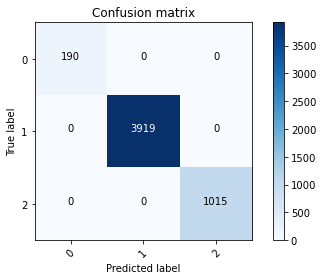

In [113]:
# Confusion Matrix for the training data
cnf_matrix_train_dt = confusion_matrix(target_train, predictions_train_dt)
np.set_printoptions(precision=2)
print("Confusion Matrix Train Data:")
plot_confusion_matrix(cnf_matrix_train_dt, classes=np.array([0,1,2]))

Confusion Matrix Test Data:


None

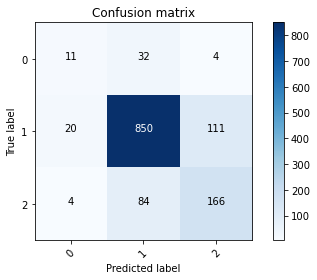

In [114]:
# Confusion Matrix for the test data
cnf_matrix_test_dt = confusion_matrix(target_test, predictions_test_dt)
np.set_printoptions(precision=2)
print("Confusion Matrix Test Data:")
display(plot_confusion_matrix(cnf_matrix_test_dt, classes=np.array([0,1,2])))

## Adoption of the Mode 
1. First Hyperparameter Tuning
2. Oversampling
3. Feature Selection
4. Second Hyperparameter Tuning

In each step the best model, which was achieved until that stage, is utilized.

### First Hyperparameter Tuning

In [115]:
# Create an estimator
decision_tree = DecisionTreeClassifier()

# Specify the parameter grid

parameters = {
    'criterion':['gini', 'entropy'], 
    'splitter':['best'],
    'max_depth':[ 2, 3, 4, 5, 6, 7, 8, 9, 10],
    'min_samples_split' :[2,3,4,5],
    'min_samples_leaf':[2,3,4,5]
}


# define the folds for the cross validation
stratified_10_fold_cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

# create the grid search estimator
grid_search_estimator = GridSearchCV(decision_tree, parameters, scoring='f1_macro', cv=stratified_10_fold_cv, n_jobs = -1, verbose = 2, return_train_score=False)

# Run the grid search
grid_search_estimator.fit(data_train, target_train)

# Print the results of all hyper-parameter combinations
results = pd.DataFrame(grid_search_estimator.cv_results_)
display(results)

print("best score is {} with params {}".format(grid_search_estimator.best_score_, grid_search_estimator.best_params_))


Fitting 10 folds for each of 288 candidates, totalling 2880 fits


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_criterion,param_max_depth,param_min_samples_leaf,param_min_samples_split,param_splitter,params,...,split3_test_score,split4_test_score,split5_test_score,split6_test_score,split7_test_score,split8_test_score,split9_test_score,mean_test_score,std_test_score,rank_test_score
0,0.008000,0.000315,0.002600,0.000200,gini,2,2,2,best,"{'criterion': 'gini', 'max_depth': 2, 'min_sam...",...,0.425593,0.409927,0.429303,0.406101,0.289086,0.402668,0.354534,0.399458,0.047776,257
1,0.007950,0.000415,0.002751,0.000250,gini,2,2,3,best,"{'criterion': 'gini', 'max_depth': 2, 'min_sam...",...,0.425593,0.409927,0.429303,0.406101,0.289086,0.402668,0.354534,0.399458,0.047776,257
2,0.008200,0.000900,0.002800,0.000400,gini,2,2,4,best,"{'criterion': 'gini', 'max_depth': 2, 'min_sam...",...,0.425593,0.409927,0.429303,0.406101,0.289086,0.402668,0.354534,0.399458,0.047776,257
3,0.008199,0.000400,0.002700,0.000245,gini,2,2,5,best,"{'criterion': 'gini', 'max_depth': 2, 'min_sam...",...,0.425593,0.409927,0.429303,0.406101,0.289086,0.402668,0.354534,0.399458,0.047776,257
4,0.008099,0.000861,0.002450,0.000150,gini,2,3,2,best,"{'criterion': 'gini', 'max_depth': 2, 'min_sam...",...,0.425593,0.409927,0.429303,0.406101,0.289086,0.402668,0.354534,0.399458,0.047776,257
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
283,0.033449,0.004623,0.002351,0.000450,entropy,10,4,5,best,"{'criterion': 'entropy', 'max_depth': 10, 'min...",...,0.562784,0.466567,0.533648,0.561093,0.528414,0.483876,0.466545,0.506827,0.038109,52
284,0.038050,0.002832,0.002800,0.000460,entropy,10,5,2,best,"{'criterion': 'entropy', 'max_depth': 10, 'min...",...,0.571150,0.451237,0.515779,0.552695,0.536741,0.484376,0.466625,0.508450,0.037133,46
285,0.039400,0.002010,0.002700,0.000510,entropy,10,5,3,best,"{'criterion': 'entropy', 'max_depth': 10, 'min...",...,0.566395,0.451237,0.541175,0.548027,0.538185,0.491544,0.485545,0.514517,0.033214,20
286,0.037800,0.004383,0.002701,0.000332,entropy,10,5,4,best,"{'criterion': 'entropy', 'max_depth': 10, 'min...",...,0.570413,0.451237,0.515779,0.557670,0.517979,0.487372,0.485545,0.509978,0.034191,39


best score is 0.5291545497872921 with params {'criterion': 'entropy', 'max_depth': 10, 'min_samples_leaf': 2, 'min_samples_split': 4, 'splitter': 'best'}


## Decision Tree with tuned parameters

In [116]:
dt_tuned = DecisionTreeClassifier(criterion="entropy", max_depth=10, min_samples_leaf=2, min_samples_split=2, splitter="best")
dt_tuned.fit(data_train, target_train)
predictions_dt_tuned_train = dt_tuned.predict(data_train)
predictions_dt_tuned_test = dt_tuned.predict(data_test)
#print("Train Data:")
#print(classification_report(target_train, dt_tuned_train, target_names=target_names))
#print("Test Data:")
#print(classification_report(target_test, dt_tuned_test, target_names=target_names))



In [117]:
get_scores_train(target_train, predictions_dt_tuned_train)
get_scores_test(target_test, predictions_dt_tuned_test)

Makro F1-Score Train Data:


0.7597339309253037

Makro Precision Train Data:


0.8282600556219064

Makro Recall Train Data:


0.7140688475815544

Makro F1-Score Test Data:


0.5380496242212732

Makro Precision Test Data:


0.5628735047339698

Makro Recall Test Data:


0.5226701646353026

Confusion Matrix Train Data:


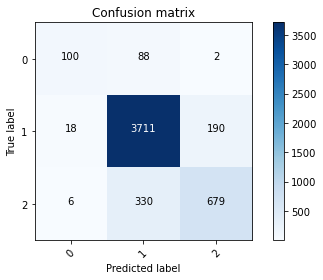

In [118]:
# Confusion Matrix for the training data
cnf_matrix_train_dt = confusion_matrix(target_train, predictions_dt_tuned_train)
np.set_printoptions(precision=2)
print("Confusion Matrix Train Data:")
plot_confusion_matrix(cnf_matrix_train_dt, classes=np.array([0,1,2]))

Confusion Matrix Test Data:


None

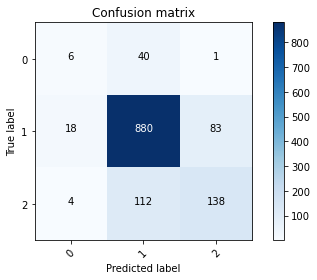

In [119]:
# Confusion Matrix for the test data
cnf_matrix_test_dt = confusion_matrix(target_test, predictions_dt_tuned_test)
np.set_printoptions(precision=2)
print("Confusion Matrix Test Data:")
display(plot_confusion_matrix(cnf_matrix_test_dt, classes=np.array([0,1,2])))

### Oversampling
On the basis of the model with the hypertuning of the parameters.

In [120]:
# Oversampling the minority class by duplicating examples --> doesn't add new information to the model --> not used
# Therefore, we use SMOTE to synthesize new examples in the minority class of the train data from the existing examples 



# Print the Class Distribution before SMOTE
print('Original Train Dataset:')
print('Length of data_train:')
display(len(data_train.index))
print('Length of target_train:')
display(target_train.size)
print('Class Distribution: %s' % Counter(target_train))

data_train_smt = data_train.copy() 
target_train_smt = target_train.copy()

smt = SMOTE(random_state=42)
data_train_oversampled, target_train_oversampled = smt.fit_resample(data_train_smt, target_train_smt)

# Print the new Class Distribution after SMOTE
print('\nBalanced Train Dataset:')
print('Length of data_train:')
display(len(data_train_oversampled.index))
print('Length of target_train:')
display(target_train_oversampled.size)
print('Class Distribution: %s' % Counter(target_train_oversampled))

Original Train Dataset:
Length of data_train:


5124

Length of target_train:


5124

Class Distribution: Counter({1: 3919, 2: 1015, 0: 190})

Balanced Train Dataset:
Length of data_train:


11757

Length of target_train:


11757

Class Distribution: Counter({1: 3919, 2: 3919, 0: 3919})


#### Decision tree with default parameters

In [121]:
dt_oversampled = DecisionTreeClassifier()
dt_oversampled.fit(data_train_oversampled, target_train_oversampled)
predictions_dt_oversampled_train = dt_oversampled.predict(data_train_oversampled)
predictions_dt_oversampled_test = dt_oversampled.predict(data_test)

get_scores_train(target_train_oversampled, predictions_dt_oversampled_train)
get_scores_test(target_test, predictions_dt_oversampled_test)

Makro F1-Score Train Data:


1.0

Makro Precision Train Data:


1.0

Makro Recall Train Data:


1.0

Makro F1-Score Test Data:


0.5569778981869286

Makro Precision Test Data:


0.535317487148001

Makro Recall Test Data:


0.6243996689886079

Confusion Matrix Train Data:


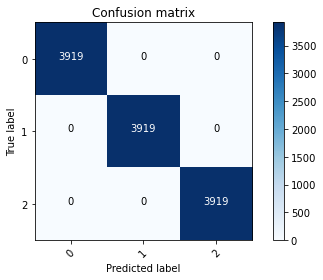

In [122]:
# Confusion Matrix for the training data
cnf_matrix_train_dt = confusion_matrix(target_train_oversampled, predictions_dt_oversampled_train)
np.set_printoptions(precision=2)
print("Confusion Matrix Train Data:")
plot_confusion_matrix(cnf_matrix_train_dt, classes=np.array([0,1,2]))

Confusion Matrix Test Data:


None

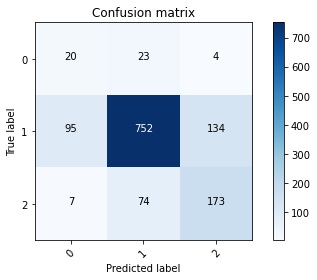

In [123]:
# Confusion Matrix for the test data
cnf_matrix_test_dt = confusion_matrix(target_test, predictions_dt_oversampled_test)
np.set_printoptions(precision=2)
print("Confusion Matrix Test Data:")
display(plot_confusion_matrix(cnf_matrix_test_dt, classes=np.array([0,1,2])))

#### Decision tree with tuned parameters

In [124]:
dt_oversampled_tuned = DecisionTreeClassifier(criterion="entropy", max_depth=10, min_samples_leaf=2, min_samples_split=2, splitter="best")
dt_oversampled_tuned.fit(data_train_oversampled, target_train_oversampled)
predictions_dt_tuned_oversampled_train = dt_oversampled_tuned.predict(data_train_oversampled)
predictions_dt_tuned_oversampled_test = dt_oversampled_tuned.predict(data_test)

get_scores_train(target_train_oversampled, predictions_dt_tuned_oversampled_train)
get_scores_test(target_test, predictions_dt_tuned_oversampled_test)

Makro F1-Score Train Data:


0.852453960757826

Makro Precision Train Data:


0.8545682436466517

Makro Recall Train Data:


0.8548949561963086

Makro F1-Score Test Data:


0.5095352638163065

Makro Precision Test Data:


0.5026732095526038

Makro Recall Test Data:


0.6401975958353634

Confusion Matrix Train Data:


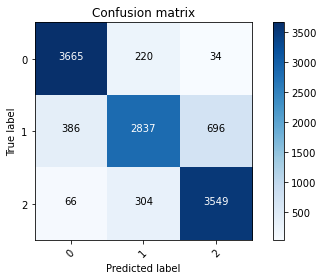

In [125]:
# Confusion Matrix for the training data
cnf_matrix_train_dt = confusion_matrix(target_train_oversampled, predictions_dt_tuned_oversampled_train)
np.set_printoptions(precision=2)
print("Confusion Matrix Train Data:")
plot_confusion_matrix(cnf_matrix_train_dt, classes=np.array([0,1,2]))

Confusion Matrix Test Data:


None

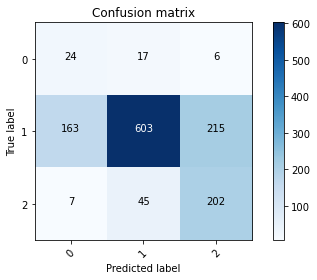

In [126]:
# Confusion Matrix for the test data
cnf_matrix_test_dt = confusion_matrix(target_test, predictions_dt_tuned_oversampled_test)
np.set_printoptions(precision=2)
print("Confusion Matrix Test Data:")
display(plot_confusion_matrix(cnf_matrix_test_dt, classes=np.array([0,1,2])))

### Feature Selection
On the basis of the model with the hypertuning of the parameters and the oversampling.

Feature: 0, Score: 0.00138
Feature: 1, Score: 0.08165
Feature: 2, Score: 0.12008
Feature: 3, Score: 0.06243
Feature: 4, Score: 0.06721
Feature: 5, Score: 0.05089
Feature: 6, Score: 0.11771
Feature: 7, Score: 0.07538
Feature: 8, Score: 0.07081
Feature: 9, Score: 0.07296
Feature: 10, Score: 0.12029
Feature: 11, Score: 0.15920


<BarContainer object of 12 artists>

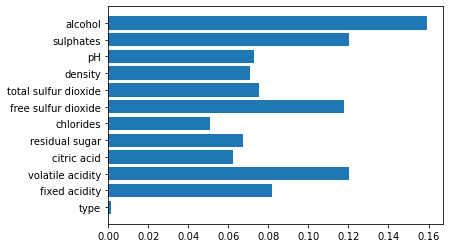

In [127]:
# get importance
importance = dt_oversampled.feature_importances_
# summarize feature importance
for i,v in enumerate(importance):
    print('Feature: %0d, Score: %.5f' % (i,v))
# plot feature importance

feature_list = list(features)
plt.barh(feature_list, importance)

Text(0.5, 0, 'Permutation Importance')

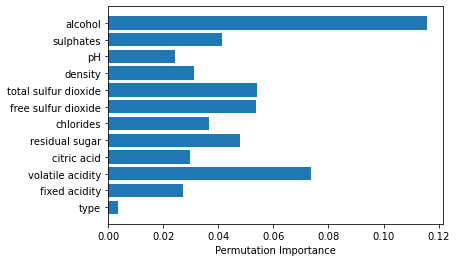

In [128]:
# Permutation Importance
from sklearn.inspection import permutation_importance
perm_importance = permutation_importance(dt_oversampled, data_test, target_test)
feature_list = list(features)
plt.barh(feature_list, perm_importance.importances_mean)
plt.xlabel("Permutation Importance")

### Drop "type" feature

In [129]:
features = wine_data.drop(columns=['quality','type'])
display(features.head())

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol
0,0.264463,0.126667,0.216867,0.308282,0.059801,0.152778,0.377880,0.267785,0.217054,0.129213,0.115942
1,0.206612,0.146667,0.204819,0.015337,0.066445,0.045139,0.290323,0.132832,0.449612,0.151685,0.217391
2,0.355372,0.133333,0.240964,0.096626,0.068106,0.100694,0.209677,0.154039,0.418605,0.123596,0.304348
3,0.280992,0.100000,0.192771,0.121166,0.081395,0.159722,0.414747,0.163678,0.364341,0.101124,0.275362
4,0.280992,0.100000,0.192771,0.121166,0.081395,0.159722,0.414747,0.163678,0.364341,0.101124,0.275362


### Model without "type" and default parameter values

In [130]:
# Create an estimator
decision_tree = DecisionTreeClassifier()

data_train, data_test, target_train, target_test = train_test_split(
    features, target,test_size=0.2, random_state=42, stratify=target)

decision_tree.fit(data_train, target_train)
predictions_train_dt = decision_tree.predict(data_train)
predictions_test_dt = decision_tree.predict(data_test)

get_scores_train(target_train, predictions_train_dt)
get_scores_test(target_test, predictions_test_dt)

Makro F1-Score Train Data:


1.0

Makro Precision Train Data:


1.0

Makro Recall Train Data:


1.0

Makro F1-Score Test Data:


0.5754580999549227

Makro Precision Test Data:


0.5764577563358051

Makro Recall Test Data:


0.5757895007089239

#### Hyperparameter tuning with "type" dropped

In [131]:
parameters = {
    'criterion':['gini', 'entropy'], 
    'splitter':['best'],
    'max_depth':[ 2, 3, 4, 5, 6, 7, 8, 9, 10],
    'min_samples_split' :[2,3,4,5],
    'min_samples_leaf':[2,3,4,5]
}


# define the folds for the cross validation
stratified_10_fold_cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

# create the grid search estimator
grid_search_estimator = GridSearchCV(decision_tree, parameters, scoring='f1_macro', cv=stratified_10_fold_cv, n_jobs = -1, verbose = 2, return_train_score=False)

# Run the grid search
grid_search_estimator.fit(data_train, target_train)

# Print the results of all hyper-parameter combinations
results = pd.DataFrame(grid_search_estimator.cv_results_)
display(results)

print("best score is {} with params {}".format(grid_search_estimator.best_score_, grid_search_estimator.best_params_))

Fitting 10 folds for each of 288 candidates, totalling 2880 fits


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_criterion,param_max_depth,param_min_samples_leaf,param_min_samples_split,param_splitter,params,...,split3_test_score,split4_test_score,split5_test_score,split6_test_score,split7_test_score,split8_test_score,split9_test_score,mean_test_score,std_test_score,rank_test_score
0,0.006800,0.000510,0.002250,0.000462,gini,2,2,2,best,"{'criterion': 'gini', 'max_depth': 2, 'min_sam...",...,0.425593,0.409927,0.429303,0.406101,0.289086,0.402668,0.354534,0.399458,0.047776,257
1,0.006998,0.000388,0.002202,0.000245,gini,2,2,3,best,"{'criterion': 'gini', 'max_depth': 2, 'min_sam...",...,0.425593,0.409927,0.429303,0.406101,0.289086,0.402668,0.354534,0.399458,0.047776,257
2,0.007000,0.000447,0.002399,0.000300,gini,2,2,4,best,"{'criterion': 'gini', 'max_depth': 2, 'min_sam...",...,0.425593,0.409927,0.429303,0.406101,0.289086,0.402668,0.354534,0.399458,0.047776,257
3,0.006850,0.000550,0.002351,0.000672,gini,2,2,5,best,"{'criterion': 'gini', 'max_depth': 2, 'min_sam...",...,0.425593,0.409927,0.429303,0.406101,0.289086,0.402668,0.354534,0.399458,0.047776,257
4,0.007100,0.001019,0.002300,0.000601,gini,2,3,2,best,"{'criterion': 'gini', 'max_depth': 2, 'min_sam...",...,0.425593,0.409927,0.429303,0.406101,0.289086,0.402668,0.354534,0.399458,0.047776,257
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
283,0.036351,0.002481,0.002600,0.000583,entropy,10,4,5,best,"{'criterion': 'entropy', 'max_depth': 10, 'min...",...,0.541720,0.493817,0.514975,0.566115,0.514774,0.529042,0.469455,0.513262,0.033116,27
284,0.034700,0.001346,0.002550,0.000270,entropy,10,5,2,best,"{'criterion': 'entropy', 'max_depth': 10, 'min...",...,0.551689,0.475448,0.518771,0.553287,0.517979,0.505482,0.460498,0.511364,0.029722,33
285,0.035199,0.001675,0.002350,0.000320,entropy,10,5,3,best,"{'criterion': 'entropy', 'max_depth': 10, 'min...",...,0.532864,0.475448,0.541175,0.559350,0.519434,0.507261,0.463725,0.515768,0.027649,17
286,0.035100,0.001546,0.002400,0.000300,entropy,10,5,4,best,"{'criterion': 'entropy', 'max_depth': 10, 'min...",...,0.537596,0.474510,0.518771,0.558758,0.517979,0.505482,0.468043,0.509306,0.026564,38


best score is 0.5328888804364326 with params {'criterion': 'entropy', 'max_depth': 10, 'min_samples_leaf': 2, 'min_samples_split': 3, 'splitter': 'best'}


### Tuned Model

In [132]:
dt_tuned = DecisionTreeClassifier(criterion="entropy", max_depth=10, min_samples_leaf=2, min_samples_split=4, splitter="best")
dt_tuned.fit(data_train, target_train)
predictions_dt_tuned_train = dt_tuned.predict(data_train)
predictions_dt_tuned_test = dt_tuned.predict(data_test)

get_scores_train(target_train, predictions_dt_tuned_train)
get_scores_test(target_test, predictions_dt_tuned_test)

Makro F1-Score Train Data:


0.7604568853858514

Makro Precision Train Data:


0.8304537320635005

Makro Recall Train Data:


0.7141539032930453

Makro F1-Score Test Data:


0.5379959768837299

Makro Precision Test Data:


0.5648053286280383

Makro Recall Test Data:


0.5226233432708477

#### Oversampling without "type"

In [133]:
# Print the Class Distribution before SMOTE
print('Original Train Dataset:')
print('Length of data_train:')
display(len(data_train.index))
print('Length of target_train:')
display(target_train.size)
print('Class Distribution: %s' % Counter(target_train))

data_train_smt = data_train.copy() 
target_train_smt = target_train.copy()

smt = SMOTE(random_state=42)
data_train_oversampled, target_train_oversampled = smt.fit_resample(data_train_smt, target_train_smt)

# Print the new Class Distribution after SMOTE
print('\nBalanced Train Dataset:')
print('Length of data_train:')
display(len(data_train_oversampled.index))
print('Length of target_train:')
display(target_train_oversampled.size)
print('Class Distribution: %s' % Counter(target_train_oversampled))

Original Train Dataset:
Length of data_train:


5124

Length of target_train:


5124

Class Distribution: Counter({1: 3919, 2: 1015, 0: 190})

Balanced Train Dataset:
Length of data_train:


11757

Length of target_train:


11757

Class Distribution: Counter({1: 3919, 2: 3919, 0: 3919})


#### Model with default parameters + oversampling

In [134]:
decision_tree_oversampled = DecisionTreeClassifier()
decision_tree_oversampled.fit(data_train_oversampled, target_train_oversampled)
predictions_train_dt = decision_tree_oversampled.predict(data_train_oversampled)
predictions_test_dt = decision_tree_oversampled.predict(data_test)

get_scores_train(target_train_oversampled, predictions_train_dt)
get_scores_test(target_test, predictions_test_dt)

Makro F1-Score Train Data:


1.0

Makro Precision Train Data:


1.0

Makro Recall Train Data:


1.0

Makro F1-Score Test Data:


0.5611639127989537

Makro Precision Test Data:


0.5397892360972661

Makro Recall Test Data:


0.6154611716544086

### Hyperparameter tuning + oversampled

In [135]:
parameters = {
    'criterion':['gini', 'entropy'], 
    'splitter':['best'],
    'max_depth':[ 2, 3, 4, 5, 6, 7, 8, 9, 10],
    'min_samples_split' :[2,3,4,5],
    'min_samples_leaf':[2,3,4,5]
}


# define the folds for the cross validation
stratified_10_fold_cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

# create the grid search estimator
grid_search_estimator = GridSearchCV(decision_tree_oversampled, parameters, scoring='f1_macro', cv=stratified_10_fold_cv, n_jobs = -1, verbose = 2, return_train_score=False)

# Run the grid search
grid_search_estimator.fit(data_train_oversampled, target_train_oversampled)

# Print the results of all hyper-parameter combinations
results = pd.DataFrame(grid_search_estimator.cv_results_)
display(results)

print("best score is {} with params {}".format(grid_search_estimator.best_score_, grid_search_estimator.best_params_))

Fitting 10 folds for each of 288 candidates, totalling 2880 fits


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_criterion,param_max_depth,param_min_samples_leaf,param_min_samples_split,param_splitter,params,...,split3_test_score,split4_test_score,split5_test_score,split6_test_score,split7_test_score,split8_test_score,split9_test_score,mean_test_score,std_test_score,rank_test_score
0,0.021954,0.001177,0.002496,0.000224,gini,2,2,2,best,"{'criterion': 'gini', 'max_depth': 2, 'min_sam...",...,0.526274,0.495025,0.524186,0.511274,0.528366,0.519004,0.542209,0.514048,0.030375,273
1,0.023100,0.000735,0.002649,0.000391,gini,2,2,3,best,"{'criterion': 'gini', 'max_depth': 2, 'min_sam...",...,0.526274,0.495025,0.524186,0.511274,0.528366,0.519004,0.542209,0.514048,0.030375,273
2,0.023451,0.000471,0.002799,0.000510,gini,2,2,4,best,"{'criterion': 'gini', 'max_depth': 2, 'min_sam...",...,0.526274,0.495025,0.524186,0.511274,0.528366,0.519004,0.542209,0.514048,0.030375,273
3,0.025398,0.002300,0.002801,0.000679,gini,2,2,5,best,"{'criterion': 'gini', 'max_depth': 2, 'min_sam...",...,0.526274,0.495025,0.524186,0.511274,0.528366,0.519004,0.542209,0.514048,0.030375,273
4,0.023900,0.001655,0.002500,0.000387,gini,2,3,2,best,"{'criterion': 'gini', 'max_depth': 2, 'min_sam...",...,0.526274,0.495025,0.524186,0.511274,0.528366,0.519004,0.542209,0.514048,0.030375,273
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
283,0.179949,0.009384,0.002650,0.000229,entropy,10,4,5,best,"{'criterion': 'entropy', 'max_depth': 10, 'min...",...,0.789120,0.804168,0.796887,0.788192,0.801892,0.779529,0.775689,0.790443,0.008776,22
284,0.174350,0.005844,0.002950,0.001036,entropy,10,5,2,best,"{'criterion': 'entropy', 'max_depth': 10, 'min...",...,0.783889,0.799008,0.796849,0.787824,0.796884,0.775364,0.777105,0.787023,0.007882,29
285,0.171649,0.006352,0.002700,0.000330,entropy,10,5,3,best,"{'criterion': 'entropy', 'max_depth': 10, 'min...",...,0.783863,0.796323,0.795965,0.788822,0.795097,0.774365,0.776946,0.786275,0.007298,31
286,0.174149,0.004285,0.002850,0.000450,entropy,10,5,4,best,"{'criterion': 'entropy', 'max_depth': 10, 'min...",...,0.782794,0.796323,0.795708,0.789783,0.797104,0.776010,0.775989,0.786944,0.007533,30


best score is 0.7979401392346589 with params {'criterion': 'gini', 'max_depth': 10, 'min_samples_leaf': 2, 'min_samples_split': 5, 'splitter': 'best'}


#### Model with tuned parameters + oversampling

In [137]:
dt_tuned_oversampled = DecisionTreeClassifier(criterion="gini", max_depth=10, min_samples_leaf=2, min_samples_split=5, splitter="best")
dt_tuned_oversampled.fit(data_train_oversampled, target_train_oversampled)
predictions_dt_tuned_train = dt_tuned_oversampled.predict(data_train_oversampled)
predictions_dt_tuned_test = dt_tuned_oversampled.predict(data_test)

get_scores_train(target_train_oversampled, predictions_dt_tuned_train)
get_scores_test(target_test, predictions_dt_tuned_test)

Makro F1-Score Train Data:


0.8587536998361825

Makro Precision Train Data:


0.8598474885628224

Makro Recall Train Data:


0.8605086331547164

Makro F1-Score Test Data:


0.5184209897466941

Makro Precision Test Data:


0.505750120816721

Makro Recall Test Data:


0.6401301389151458